### CS 421 PROJECT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = np.load("first_batch_multi_labels.npz")
X = pd.DataFrame(data["X"])
y = pd.DataFrame(data["y"])
yy = pd.DataFrame(data["yy"])

In [3]:
X = data["X"]
y = data["yy"]

XX = pd.DataFrame(X)
yy = pd.DataFrame(y)
XX.rename(columns={0: "user", 1: "item", 2: "rating"}, inplace=True)
yy.rename(columns={0: "user", 1: "label"}, inplace=True)

In [4]:
# Combine the two dataframes where the user is the same
merged_df = pd.merge(XX, yy, on="user")
merged_df.sample(50)

,user,item,rating,label
21886,56,708,1,0
42911,535,263,1,0
93600,566,623,1,0
45632,1021,378,10,0
98190,837,261,1,0
56651,499,875,10,0
52783,183,692,1,0
109364,184,975,1,0
113844,754,542,10,0
125617,276,625,1,0


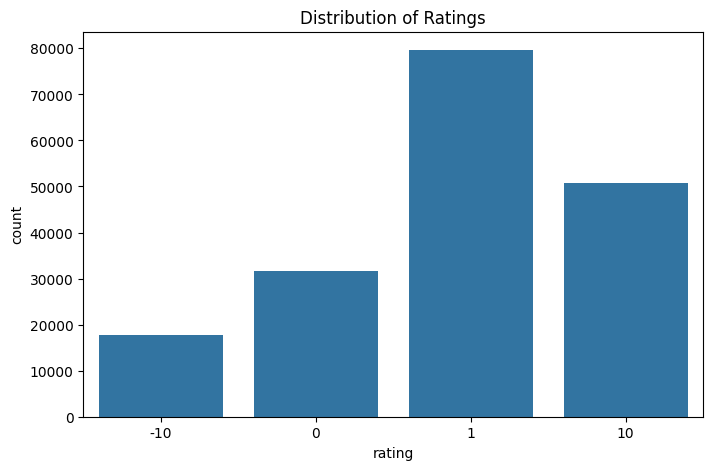

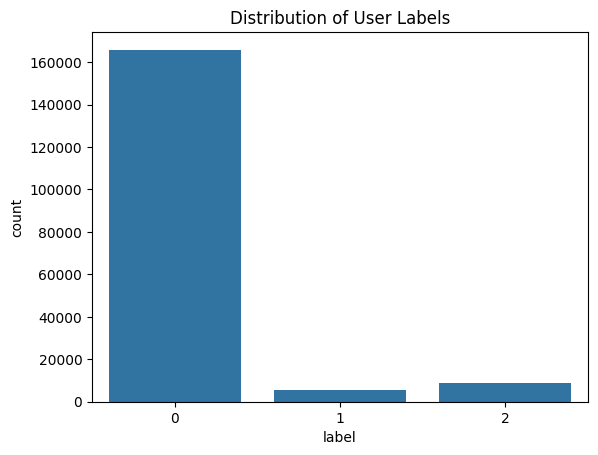

In [5]:
# Checking rating distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="rating", data=merged_df)
plt.title("Distribution of Ratings")
plt.show()

# Label distribution in yy
sns.countplot(x="label", data=merged_df)
plt.title("Distribution of User Labels")
plt.show()

<Figure size 1000x600 with 0 Axes>

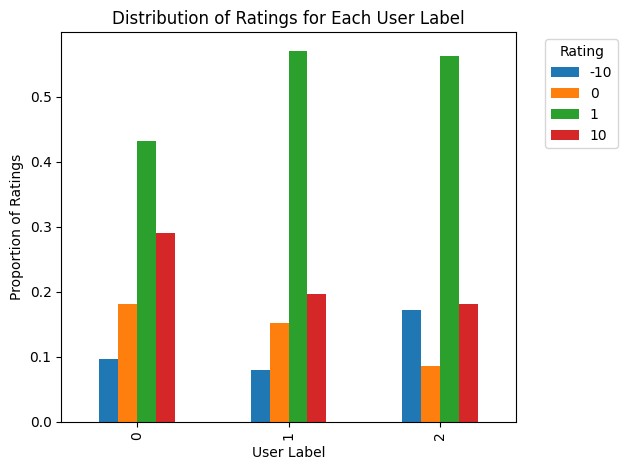

In [6]:
# Group by the label and the rating to count occurrences
rating_distribution = (
    merged_df.groupby(["label", "rating"]).size().unstack(fill_value=0)
)

# Normalize to get the distribution for each label
rating_distribution_norm = rating_distribution.div(
    rating_distribution.sum(axis=1), axis=0
)

# Plotting the distribution of ratings for each label
plt.figure(figsize=(10, 6))
rating_distribution_norm.plot(kind="bar", stacked=False)

# Add labels and title
plt.title("Distribution of Ratings for Each User Label")
plt.xlabel("User Label")
plt.ylabel("Proportion of Ratings")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")

# Display the plot
plt.tight_layout()
plt.show()

In [7]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Step 1: Pivot the data to create the user-item matrix
user_item_matrix = merged_df.pivot_table(
    index="user", columns="item", values="rating", fill_value=0
)

# Split the data into training and test sets
labels = yy.set_index("user")["label"]
X_train, X_test, y_train, y_test = train_test_split(
    user_item_matrix, labels, test_size=0.3, random_state=42
)

# Step 2: Apply scaling and PCA on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on the training data
X_test_scaled = scaler.transform(X_test)  # Only transform the test data

pca = PCA(n_components=50)  # Reduce the dimensionality to 50 components
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit PCA on the training data
X_test_pca = pca.transform(X_test_scaled)  # Only transform the test data

# Step 3: Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

# Step 4: Make predictions and evaluate the performance
y_prob = clf.predict_proba(X_test_pca)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
print(f"AUC Score: {auc}")

AUC Score: 0.7641106875979952


In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, roc_auc_score

# Step 1: Split data into train+val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    user_item_matrix, labels, test_size=0.2, random_state=42
)

# Step 2: Split train+val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2

# Step 3: Apply scaling and PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 4: Define parameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

# Step 5: Perform Grid Search with cross-validation
rf = RandomForestClassifier(random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scorer
)
grid_search.fit(X_train_pca, y_train)

# Step 6: Print best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Step 7: Evaluate on validation set
best_rf = grid_search.best_estimator_
y_val_prob = best_rf.predict_proba(X_val_pca)
val_auc = roc_auc_score(y_val, y_val_prob, multi_class="ovr")
print(f"Validation AUC Score: {val_auc}")

# Step 8: Final evaluation on test set
y_test_prob = best_rf.predict_proba(X_test_pca)
test_auc = roc_auc_score(y_test, y_test_prob, multi_class="ovr")
print(f"Test AUC Score: {test_auc}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/milton/Documents/GitHub/cs421-project/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None,

In [9]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

# Step 1: Define the K-fold cross-validation strategy
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Step 2: Create a pipeline for preprocessing and model fitting
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),  # Handle missing values
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=50)),
        ("rf", RandomForestClassifier(random_state=42)),
    ]
)

# Step 3: Define expanded parameter grid for Random Forest
param_grid = {
    "rf__n_estimators": [200],
    "rf__max_depth": [10],
    "rf__min_samples_split": [10],
    "rf__min_samples_leaf": [4],
    "rf__max_features": ["log2"],
}

# Step 4: Perform Grid Search with K-fold cross-validation
scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    scoring=scorer,
)

# Fit the grid search
grid_search.fit(user_item_matrix, labels)

# Step 5: Print best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Step 6: Evaluate using cross-validation
best_pipeline = grid_search.best_estimator_
cv_scores = cross_val_score(
    best_pipeline, user_item_matrix, labels, cv=cv, scoring=scorer
)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/milton/Documents/GitHub/cs421-project/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=200; total time=   0.5s
[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=200; total time=   0.5s
[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=200; total time=   0.5s
[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=200; total time=   0.5s
[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=200; total time=   0.5s
Best parameters found:  {'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best cross-validation score: 0.83
Cross-validation scores: [0.80246032 0.87521032 0.83794048 0.82232937 0.82590079]
Mean CV Score: 0.8328 (+